# I. Introduction
**Name** : Dafa Wiratama
**Batch** : Data Science - Batch 09

> ## Overview
> Millions of stray animals suffer on the streets or are euthanized in shelters every day around the world. If homes can be found for them, many precious lives can be saved — and more happy families created.
>
> PetFinder.my has been Malaysia’s leading animal welfare platform since 2008, with a database of more than 150,000 animals. PetFinder collaborates closely with animal lovers, media, corporations, and global organizations to improve animal welfare.
>
> Animal adoption rates are strongly correlated to the metadata associated with their online profiles, such as descriptive text and photo characteristics. As one example, PetFinder is currently experimenting with a simple AI tool called the Cuteness Meter, which ranks how cute a pet is based on qualities present in their photos.
>
> In this competition you will be developing algorithms to predict the adoptability of pets - specifically, how quickly is a pet adopted? If successful, they will be adapted into AI tools that will guide shelters and rescuers around the world on improving their pet profiles' appeal, reducing animal suffering and euthanization.
>
> Top participants may be invited to collaborate on implementing their solutions into AI tools for assessing and improving pet adoption performance, which will benefit global animal welfare.
>
> PetFinder-Dataset : [https://www.kaggle.com/c/petfinder-adoption-prediction/data](https://www.kaggle.com/c/petfinder-adoption-prediction/data)

> ## Data Fields
> - PetID - Unique hash ID of pet profile
> - AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
> - Type - Type of animal (1 = Dog, 2 = Cat)
> - Name - Name of pet (Empty if not named)
> - Age - Age of pet when listed, in months
> - Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
> - Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
> - Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
> - Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
> - Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
> - Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
> - MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
> - FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
> - Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
> - Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
> - Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
> - Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
> - Quantity - Number of pets represented in profile
> - Fee - Adoption fee (0 = Free)
> - State - State location in Malaysia (Refer to StateLabels dictionary)
> - RescuerID - Unique hash ID of rescuer
> - VideoAmt - Total uploaded videos for this pet
> - PhotoAmt - Total uploaded photos for this pet
> - Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

> ## AdoptionSpeed
>> Contestants are required to predict this value. The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way:
> - 0 : Pet was adopted on the same day as it was listed.
> - 1 : Pet was adopted between 1 and 7 days (1st week) after being listed.
> - 2 : Pet was adopted between 8 and 30 days (1st month) after being listed.
> - 3 : Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
> - 4 : No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

> ## Objective
> - Analyze the dataset and find the best feature and model to predict the adoptability of pets.
> - create an interactive dashboard to calculate the probability of adoption of a pet.
> - Use the probability output to guide rescuers and shelters around the world on improving their pet profiles' appeal, reducing animal suffering and euthanization.

# II. Import Libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from scipy.stats import gaussian_kde
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import classification_report, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, PowerTransformer
import pickle
from utils import *

from deployment.backend.datasets.PetFinderDataset import PetFinderDataset

warnings.filterwarnings("ignore")

In [2]:
RANDOM_SEED = 13

# III. Data Loading

In [3]:
dataset = PetFinderDataset(".\\deployment\\backend\\datasets\\csv")

> from the frame information we can see that the dataset contains around 15.000 rows and around 23 columns, and some missing value in the dataset.

In [4]:
dataset.original_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Type           14993 non-null  int64 
 1   Name           13736 non-null  object
 2   Age            14993 non-null  int64 
 3   Breed1         14993 non-null  int64 
 4   Breed2         14993 non-null  int64 
 5   Gender         14993 non-null  int64 
 6   Color1         14993 non-null  int64 
 7   Color2         14993 non-null  int64 
 8   Color3         14993 non-null  int64 
 9   MaturitySize   14993 non-null  int64 
 10  FurLength      14993 non-null  int64 
 11  Vaccinated     14993 non-null  int64 
 12  Dewormed       14993 non-null  int64 
 13  Sterilized     14993 non-null  int64 
 14  Health         14993 non-null  int64 
 15  Quantity       14993 non-null  int64 
 16  Fee            14993 non-null  int64 
 17  State          14993 non-null  int64 
 18  RescuerID      14993 non-n

> from the statistical information we can see that there are some outlier in the data, but we're still calculating the categorical data as numerical data. so we will need to split them into different analysis.

In [5]:
dataset.original_dataframe.describe()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,1.457614,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,1.467485,1.731208,1.558727,1.914227,1.036617,1.576069,21.259988,41346.028347,0.056760,3.889215,2.516441
std,0.498217,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,0.599070,0.667649,0.695817,0.566172,0.199535,1.472477,78.414548,32.444153,0.346185,3.487810,1.177265
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000,2.000000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000,2.000000
75%,2.000000,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000,4.000000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,8.000000,30.000000,4.000000


> as you can see here is the original dataset that we will use to train our model. but for analysis purpose we will revert the dataset to the original dataset. in this case string base feature, so it will be easy to understand on human perspective.

In [6]:
dataset.original_dataframe

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,NaN,2,266,0,3,1,0,0,2,...,1,4,0,41326,61c84bd7bcb6fb31d2d480b1bcf9682e,0,I have 4 kittens that need to be adopt urgentl...,dc0935a84,3,2
14989,2,Serato & Eddie,60,265,264,3,1,4,7,2,...,1,2,0,41326,1d5096c4a5e159a3b750c5cfcf6ceabf,0,Serato(female cat- 3 color) is 4 years old and...,a01ab5b30,3,4
14990,2,Monkies,2,265,266,3,5,6,7,3,...,1,5,30,41326,6f40a7acfad5cc0bb3e44591ea446c05,0,"Mix breed, good temperament kittens. Love huma...",d981b6395,5,3
14991,2,Ms Daym,9,266,0,2,4,7,0,1,...,1,1,0,41336,c311c0c569245baa147d91fa4e351ae4,0,she is very shy..adventures and independent..s...,e4da1c9e4,3,4


> A lot better than the original dataset.
>> **Side Note** :
>> all the conversion was done in the backend or in this case on another module because i want to save time by not doing it again and again. because we will use the dataset in the backend.

In [7]:
dataset.dataframe

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,Description,PhotoAmt,AdoptionSpeed
PetID,,,,,,,,,,,,,,,,,,,,,
86e1089a3,Cat,Nibble,3,Tabby,Not Specified,Male,Black,White,Not Specified,Small,...,No,No,Healthy,1,100,Selangor,0,Nibble is a 3+ month old ball of cuteness. He ...,1,2
6296e909a,Cat,No Name Yet,1,Domestic Medium Hair,Not Specified,Male,Black,Brown,Not Specified,Medium,...,Not Sure,Not Sure,Healthy,1,0,Kuala Lumpur,0,I just found it alone yesterday near my apartm...,2,0
3422e4906,Dog,Brisco,1,Mixed Breed,Not Specified,Male,Brown,White,Not Specified,Medium,...,Yes,No,Healthy,1,0,Selangor,0,Their pregnant mother was dumped by her irresp...,7,3
5842f1ff5,Dog,Miko,4,Mixed Breed,Not Specified,Female,Black,Brown,Not Specified,Medium,...,Yes,No,Healthy,1,150,Kuala Lumpur,0,"Good guard dog, very alert, active, obedience ...",8,2
850a43f90,Dog,Hunter,1,Mixed Breed,Not Specified,Male,Black,Not Specified,Not Specified,Medium,...,No,No,Healthy,1,0,Selangor,0,This handsome yet cute boy is up for adoption....,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dc0935a84,Cat,NaN,2,Domestic Short Hair,Not Specified,Mixed,Black,Not Specified,Not Specified,Medium,...,No,No,Healthy,4,0,Selangor,0,I have 4 kittens that need to be adopt urgentl...,3,2
a01ab5b30,Cat,Serato & Eddie,60,Domestic Medium Hair,Domestic Long Hair,Mixed,Black,Yellow,White,Medium,...,Yes,Yes,Healthy,2,0,Selangor,0,Serato(female cat- 3 color) is 4 years old and...,3,4
d981b6395,Cat,Monkies,2,Domestic Medium Hair,Domestic Short Hair,Mixed,Cream,Gray,White,Large,...,Yes,Not Sure,Healthy,5,30,Selangor,0,"Mix breed, good temperament kittens. Love huma...",5,3


# IV. Exploratory Data Analysis
> in this section we will perform some visualizations and data analysis to understand the data better

In [8]:
def calc_kernel_density(values, n_space=128):
    _space = np.linspace(values.min(), values.max(), n_space)
    _kde = gaussian_kde(values)(_space)
    return _space, _kde

In [9]:
def plot_class_distribution(df, column, target, cumulative=True, n_space=128, ax=plt):
    cumulative_kde = []

    for class_name in sorted(df[target].unique()):
        _values = df[df[target] == class_name][column]
        _space, _kde = calc_kernel_density(_values, n_space)
        cumulative_kde.append((_space, _kde))
        ax.plot(_space, _kde, label=class_name)

    if cumulative:
        space, kde = np.zeros(n_space), np.zeros(n_space)
        for _space, _kde in cumulative_kde:
            space = np.linspace(min(min(_space), space.min()), max(max(_space), space.max()), n_space)
            kde += _kde
        ax.plot(space, kde, linestyle=':', label='Cumulative')

        _mean = df[column].mean()

        ax.axvline(_mean, linestyle='--', color='b', label='Mean')
        ax.axvline(df[column].median(), linestyle='--', color='r', label='Median')

        iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
        lower_bound = (df[column].quantile(0.25) - 3 * iqr) - _mean
        upper_bound = (df[column].quantile(0.75) + 3 * iqr) - _mean

        if lower_bound > df[column].min():
            ax.axvline(lower_bound, linestyle='--', color='y', label='Bound')

        if upper_bound < df[column].max():
            ax.axvline(upper_bound, linestyle='--', color='y', label='Bound')

    ax.legend()

In [10]:
def plot_numerical_analysis(df, column, target, category=None, transformer=None, n_space=128):
    df = df.copy()

    categories = df[category].unique() if category else []

    fig, ax = plt.subplots(1, 2 + len(categories), figsize=(8 * 4, 6))
    fig.suptitle(column)

    plot_class_distribution(df, column, target, n_space=n_space, ax=ax[0])
    ax[0].set_title(f'Feature Distribution')

    if transformer:
        df[column] = transformer.fit_transform(df[column].values.reshape(-1, 1))
        plot_class_distribution(df, column, target, n_space=n_space, ax=ax[-1])
        ax[3].set_title(f'Transformed Distribution')
    else:
        ax[3].remove()

    for i, cat in enumerate(categories):
        plot_class_distribution(df[df[category] == cat], column, target, n_space=n_space, ax=ax[1 + i], cumulative=False)
        ax[1 + i].set_title(f'{(cat + " Transformed") if transformer else cat} Distribution')

> ## Shallow Analysis
> first we will plot the correlation of the features, and from the visualization they are no apparent correlations between the features i think this is cause by the fact that the features are mostly categorical

<AxesSubplot:>

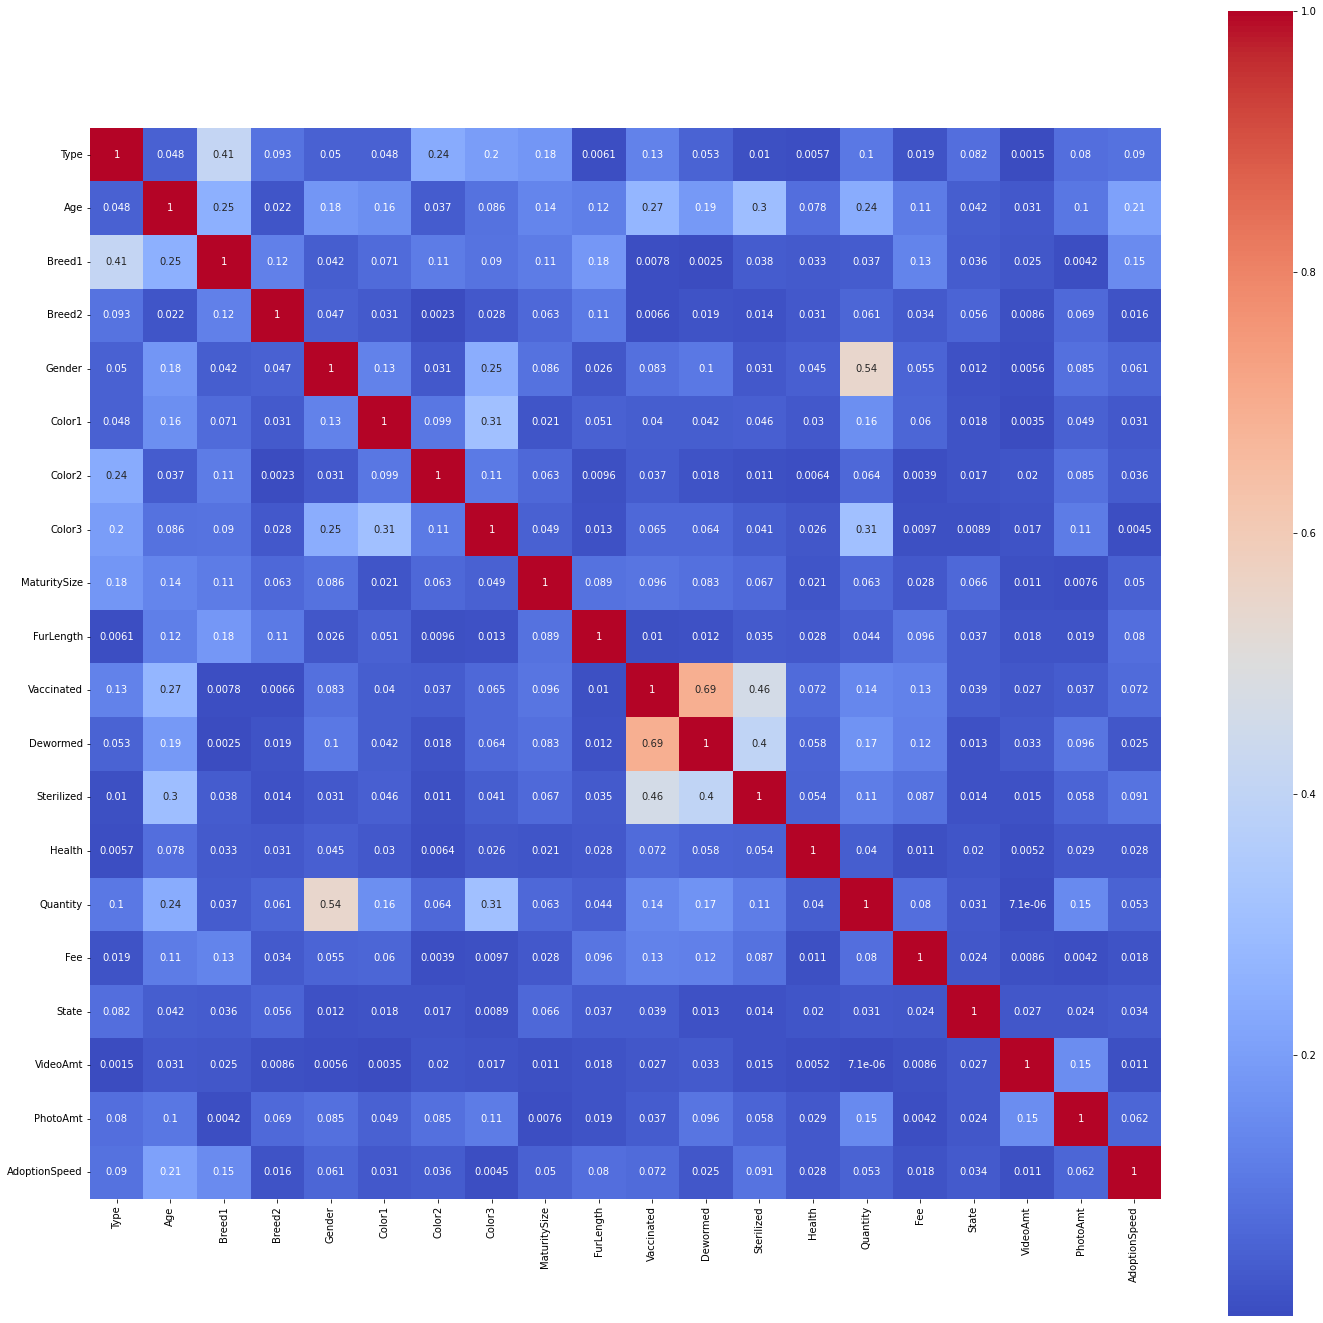

In [11]:
_corr = dataset.original_dataframe.corr('spearman').abs()

plt.figure(figsize=(8 * 3, 8 * 3))
sns.heatmap(_corr, annot=True, cmap='coolwarm', square=True)

> so to better understand the data i will plot the numerical columns with scatter plot to see is there a pattern in the feature.
> but again from the scatter plot we can see that there is no pattern and the distribution between the features is not very clear among the target classes

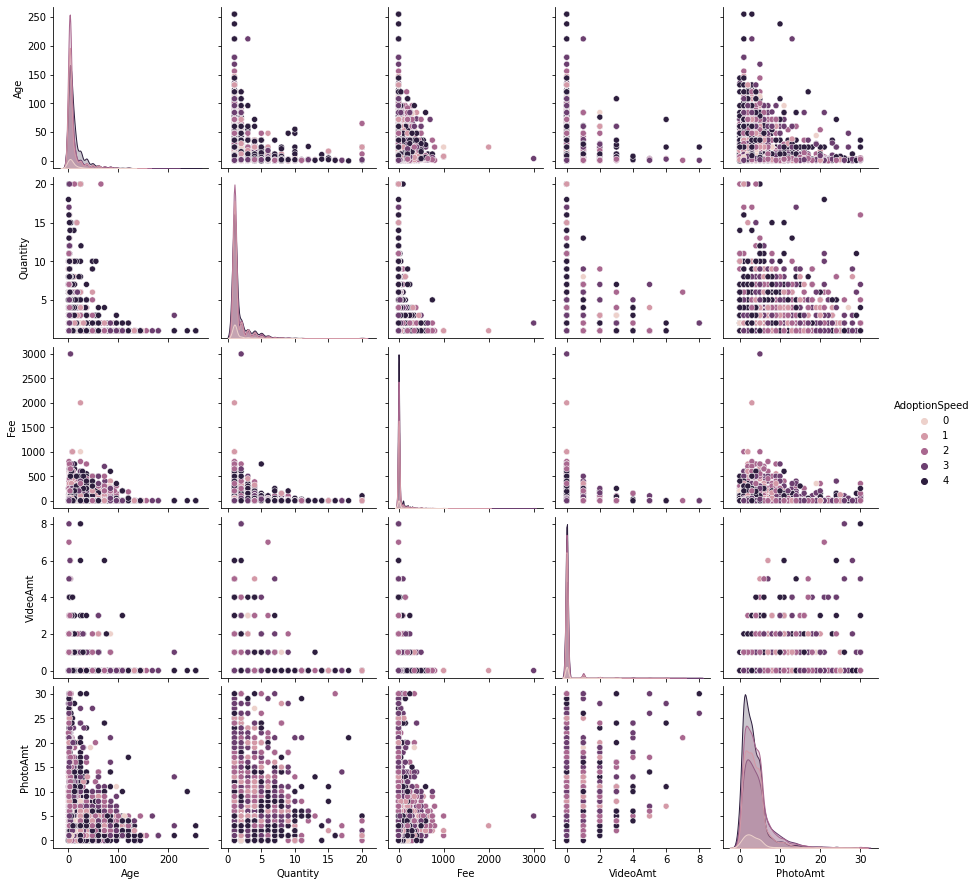

In [12]:
sns.pairplot(dataset.dataframe, hue='AdoptionSpeed')

> so after the visualisation i will try to rank the correlation that we got from the numerical analysis. but yet there is low correlation between the features at most the best feature to be corelated with the target is the age and it is only 20% of the correlation.

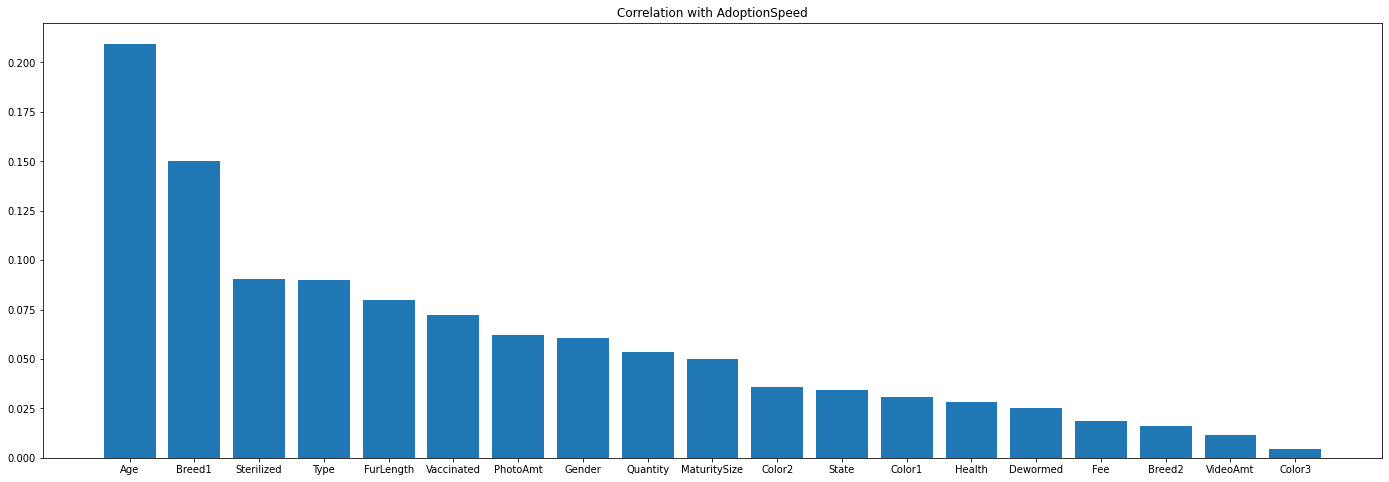

In [13]:
plt.figure(figsize=(8 * 3, 8))
plt.bar(_corr['AdoptionSpeed'].sort_values(ascending=False).drop('AdoptionSpeed').index,
        _corr['AdoptionSpeed'].sort_values(ascending=False).drop('AdoptionSpeed').values)
plt.title('Correlation with AdoptionSpeed');

> ## Numerical Analysis
> in this case we will start to analyse the distribution of the numerical features.

>> ### Age
>> from the histogram bellow the age feature seem to have very skewed distribution but we can normalize it by using Power Transformation and there is no apparent outlier.
>> we can get some insight by looking at the distribution that the younger the pet is the more likely to be adopted faster.

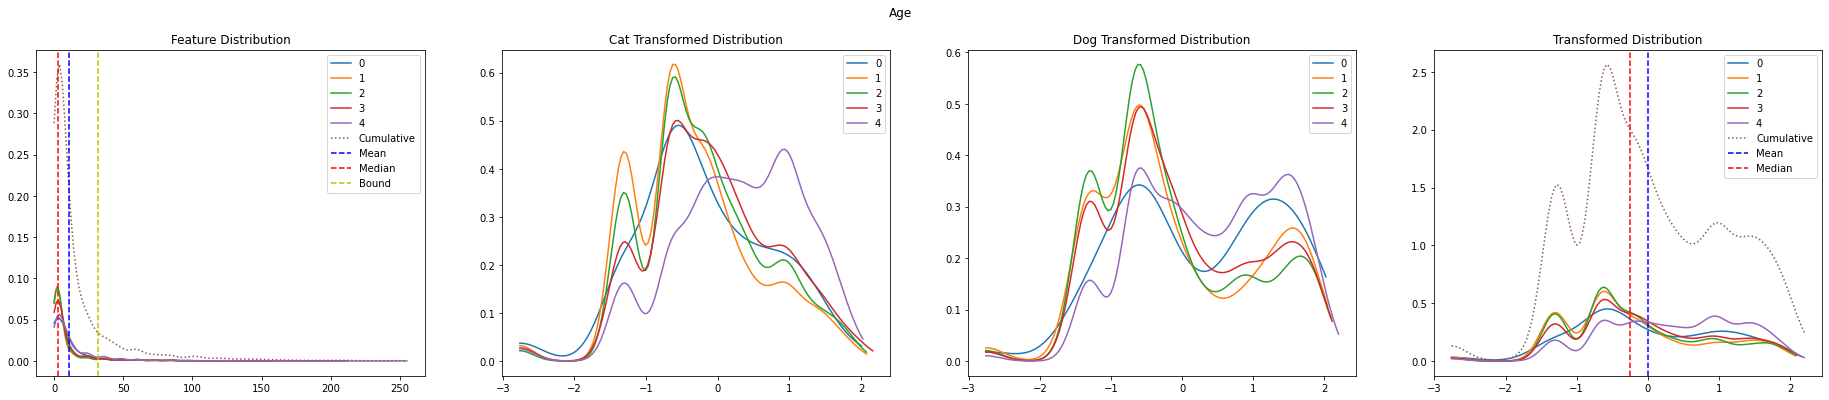

In [14]:
plot_numerical_analysis(dataset.dataframe, column='Age', target='AdoptionSpeed', category='Type', transformer=PowerTransformer())

>> ### Fee
>> this feature is skewed like before but this time the Power Transformation can't help us because the distribution still not look like normal.
>> so people are more likely to adopt the pet when it is free of charge that make sense but at the end of the distribution there are some people who are more likely to adopt the pet when there is associated fee it in this is because some Race of pet has a tendency to be more expensive that other

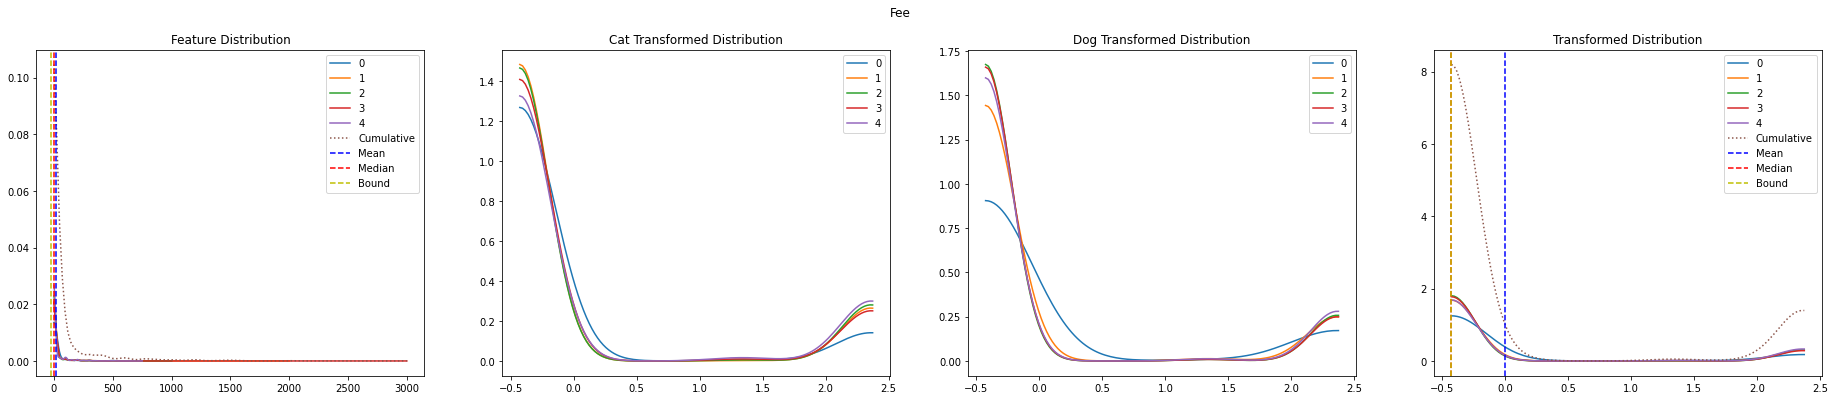

In [15]:
plot_numerical_analysis(dataset.dataframe, column='Fee', target='AdoptionSpeed', category='Type', transformer=PowerTransformer())

>> ### PhotoAmt
>> and on this feature there was no apparent way to distinguish the classes but some classes have higher probability at certain number of photo.
>> okay this is quite apparent that more people will be adopting the pet when it has a picture associated with it. because i think logically no one want to adopt a cat in a bag

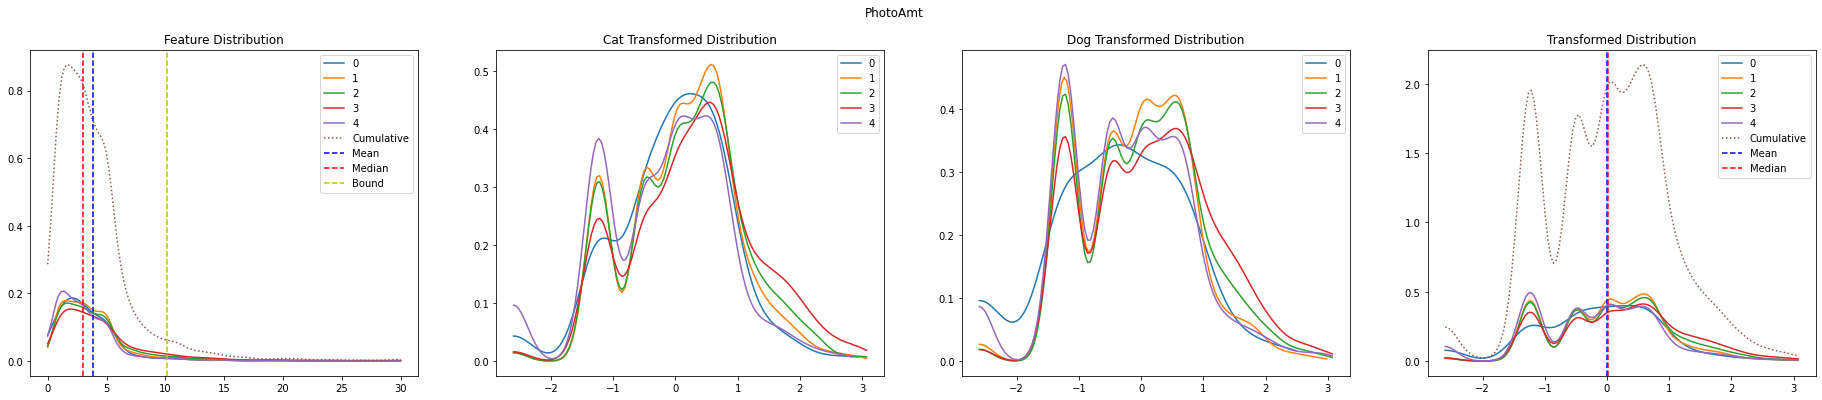

In [16]:
plot_numerical_analysis(dataset.dataframe, column='PhotoAmt', target='AdoptionSpeed', category='Type', transformer=PowerTransformer())

>> ### VideoAmt
>> this feature is about the amount of videos that the pet has on the website. from the distribution we can say that if the pet has no video it is take longger to adopt than if the pet has a video. this is the same like the photo feature.

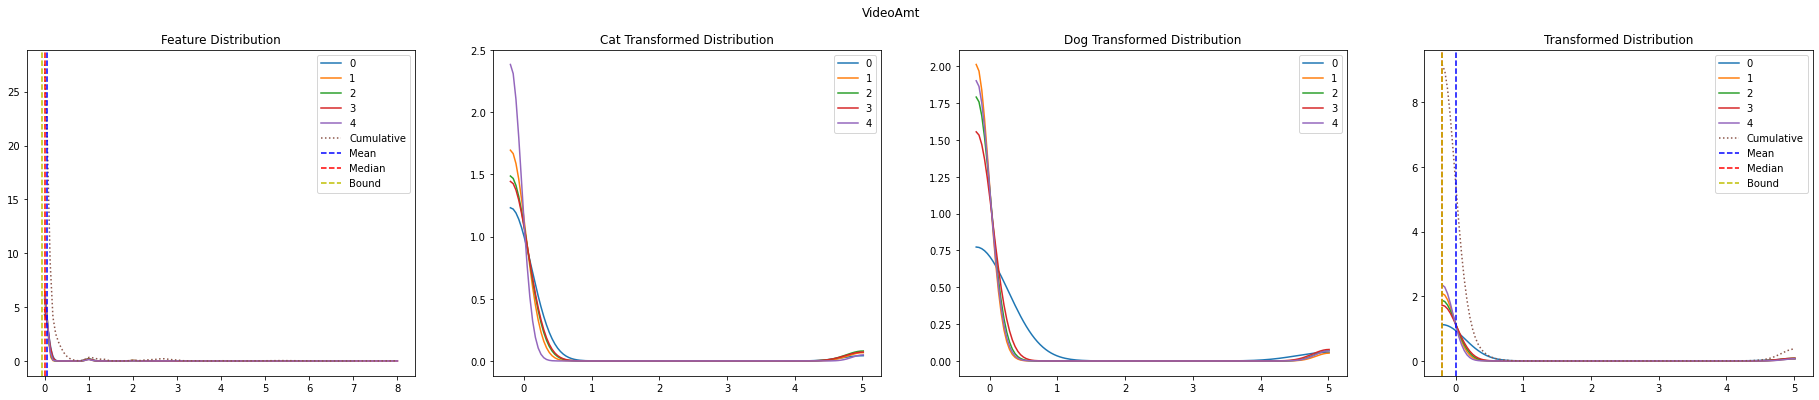

In [17]:
plot_numerical_analysis(dataset.dataframe, column='VideoAmt', target='AdoptionSpeed', category='Type', transformer=PowerTransformer())

>> ### Quantity
>> quantity is the amount of the pet in the shelter. from the distribution we can see that the amount of the pet is not very clear. but there is a insight that higher quantity of the pet is more likely to be adopted. i think this is because when there are many pet within the same post it is more likely to be adopted by local pet shelter.

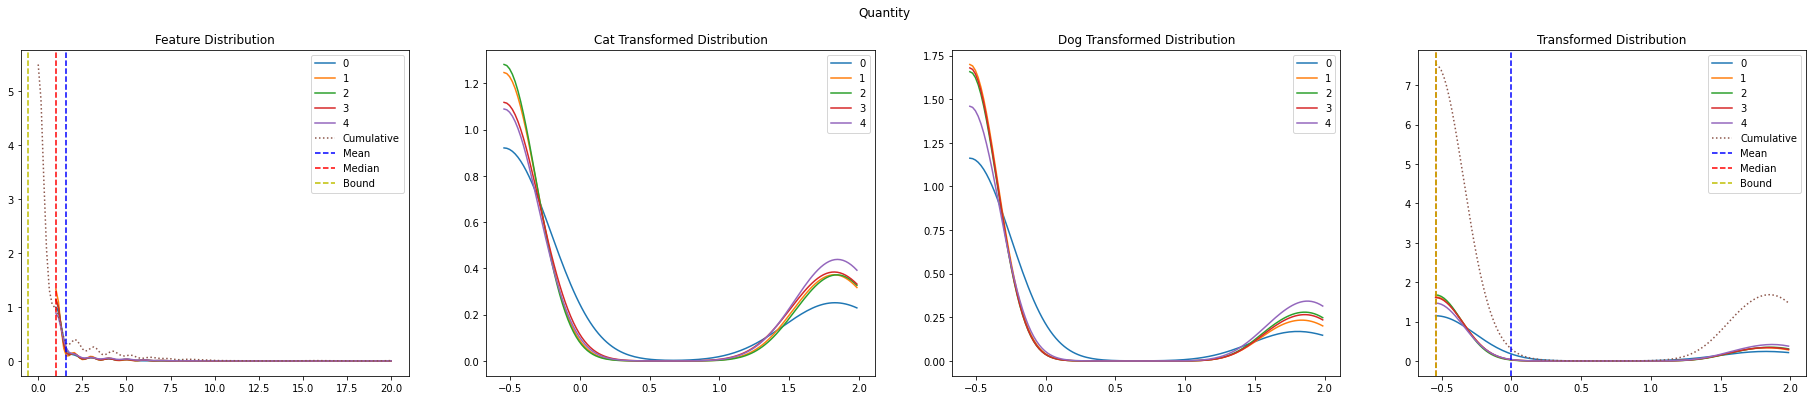

In [18]:
plot_numerical_analysis(dataset.dataframe, column='Quantity', target='AdoptionSpeed', category='Type', transformer=PowerTransformer())

> ## Categorical Analysis

In [19]:
def plot_categorical_analysis(df, *columns):
    fig, ax = plt.subplots(1, len(columns), figsize=(8 * len(columns), 4))

    for i, column in enumerate(columns):
        _ax = ax[i] if len(columns) > 1 else ax
        sns.histplot(data=df, x=column, hue='AdoptionSpeed', multiple="dodge", stat='probability', shrink=0.5, ax=_ax, palette='Set1')
        _ax.set_title(f'{column} Distribution')

>> we will try to find some pattern to diffrentiate the classes in the categorical features. but from the visualisation there is no apparent pattern. but from the Color1 feature there is a spike in color black with in this case mean that most peaces are like black cat/dog. and doest like mixed gender in this case adopt multiple pet at same time

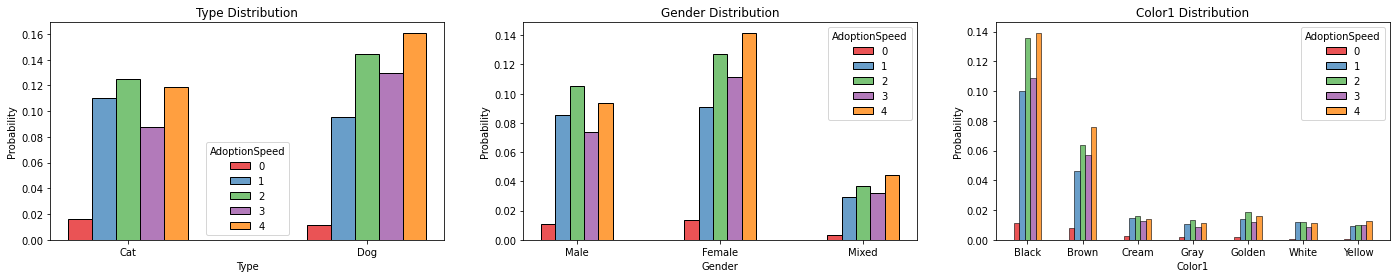

In [20]:
plot_categorical_analysis(dataset.dataframe, 'Type', 'Gender', 'Color1')

>> people are like the Medium pet MatureSize more than any other Size this is because they are more cute when small, and it is good to have cute pet when there is a kid around
>
>> from the distribution of the FurLength we can say that more people are adopting the pet with the short fur length.
>
>> from the Health feature we can see that the pet with the health feature is more likely to be adopted.

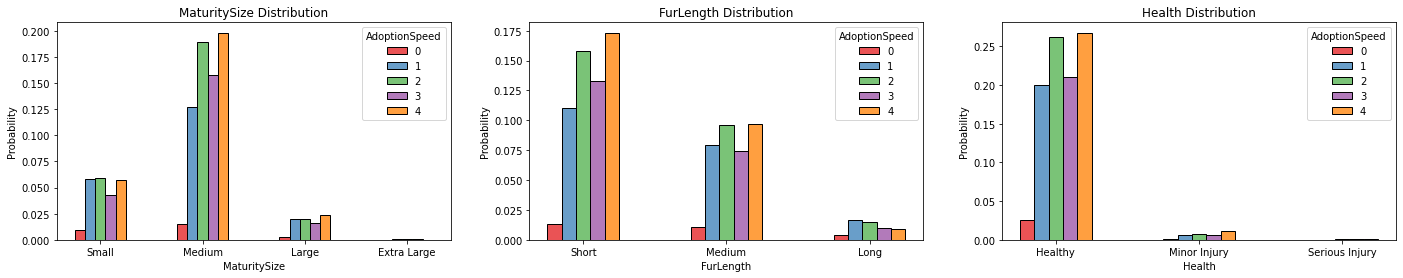

In [21]:
plot_categorical_analysis(dataset.dataframe, 'MaturitySize', 'FurLength', 'Health')

>> Vaccinated and Dewormed are the most important features to adopt a pet because i think people are like when their pet doest cary a pest with them
>
>> but for Sterilized feature more people adopt the pet that not sterilized yet.

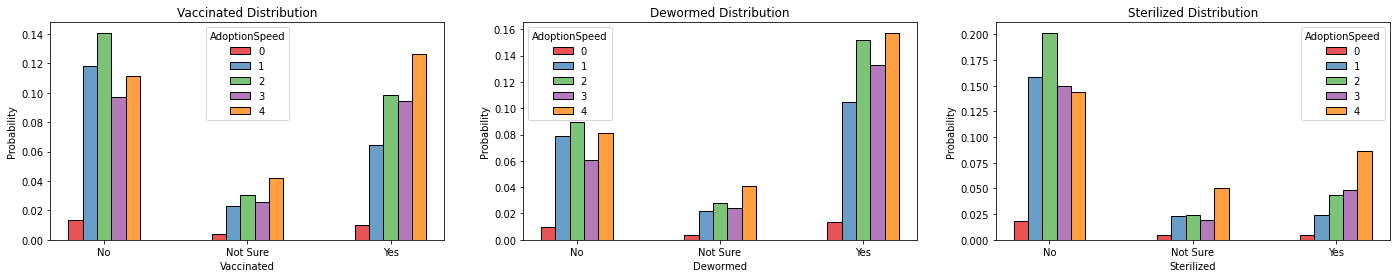

In [22]:
plot_categorical_analysis(dataset.dataframe, 'Vaccinated', 'Dewormed', 'Sterilized')

> # Semantic Analysis
> this dataset contain text base feature that we can exploit but in this project we will be limiting our self to only use simple and small model so we will only encode those text feature into number in this case we will only count the number of words in the desc feature and character in the name feature.

> ## Feature Selection
> after all feature is analysed we will pick our best feature to use in our model. but after some consideration i will not drop any feature. this is because i cannot make any conclusion from the analysis and class distribution is similar to each other. so i will put the burden on the model (Random Forest) to decide which feature to use.

In [23]:
tree_model = DecisionTreeClassifier(random_state=RANDOM_SEED)

x_train, y_train = dataset.x_train.copy(), dataset.y_train.copy()
x_val, y_val = dataset.x_val.copy(), dataset.y_val.copy()

categorical_column = x_train.select_dtypes(exclude=['number']).columns

x_train[categorical_column] = x_train[categorical_column].apply(lambda x: x.astype('category').cat.codes)
x_val[categorical_column] = x_val[categorical_column].apply(lambda x: x.astype('category').cat.codes)

tree_model.fit(x_train, y_train)

_y = tree_model.predict(x_val)

pd.DataFrame(np.array([x_train.columns, tree_model.feature_importances_]).T, columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

,Feature,Importance
19,Description,0.181053
1,Name,0.164945
2,Age,0.08406
20,PhotoAmt,0.076456
6,Color1,0.05529
7,Color2,0.053405
3,Breed1,0.049504
17,State,0.04201
4,Breed2,0.040838
16,Fee,0.030561


> still same conclusion from the random forest feature importance. so no column is dropped in this dataset we will proceed to the next step.

# V. Data Preprocessing
> since this dataset is mostly categorical value we need to carefully pick preprocessing method to convert the categorical value to numerical value.
> in this case i will separate the categorical with ordinal and categorical without ordinal.
> and for the numeric value i will use the PowerTransformer because in the EDA it has proven to help us normalize the distribution.

In [24]:
preprocessing_pipeline = ColumnTransformer([
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999),
     ['Type', 'Dewormed', 'Sterilized', 'Health', 'Vaccinated', 'State', 'MaturitySize', 'FurLength', 'Gender']),
    ('ohe', OneHotEncoder(handle_unknown='ignore'), ['Breed1', 'Breed2', 'Color1', 'Color2', 'Color3']),
    ('name_transformer', CharacterCounter(), ['Name']),
    ('desc_transformer', WordCounter(), ['Description']),
    ('scaler', PowerTransformer(), ['Age', 'Fee', 'Quantity', 'VideoAmt', 'PhotoAmt']),
])

create_model_pipeline = lambda model: Pipeline([
    ('ordinal_encoder', preprocessing_pipeline),
    ('model', model)
])

In [25]:
dataset.y_train.value_counts()

4    3357
2    3230
3    2607
1    2472
0     328
Name: AdoptionSpeed, dtype: int64

> since we have imbalance in some of the class we will use weighted loss to balance the dataset so the model will not forget about the importance of all classes in this case class 0 with mean `Will be adopted today`

In [26]:
n = dataset.y_train.value_counts()
total = n.sum()

class_weight = {
    0: (1 / n[0]) * (total / 5),
    1: (1 / n[1]) * (total / 5),
    2: (1 / n[2]) * (total / 5),
    3: (1 / n[3]) * (total / 5),
    4: (1 / n[4]) * (total / 5)
}

# VI. Model Definition
> for this model we will be using 4 model and will test their ability to predict the class.
> we will use the following model:
> 1. Logistic Regression
> 2. SVM
> 3. LightGBM
> 4. AdaBoost
>
> i will not use any deep learning method since this is small dataset because of that the deep leaning method will not be able to generalize well. and the tree base model will be shining here because it is known that tree model is the best model for small this dataset.

In [27]:
loreg_model = create_model_pipeline(
    LogisticRegression(
        max_iter=1000,
        class_weight=class_weight,
        random_state=RANDOM_SEED
    )
)

In [28]:
svm_model = create_model_pipeline(
    SVC(
        max_iter=1000,
        probability=True,
        class_weight=class_weight,
        random_state=RANDOM_SEED
    )
)

In [29]:
lgbm_model = create_model_pipeline(
    LGBMClassifier(
        n_estimators=128,
        num_leaves=128,
        max_depth=7,
        learning_rate=.1,
        boosting_type='dart',
        class_weight=class_weight,
        random_state=RANDOM_SEED
    )
)

In [30]:
ada_model = create_model_pipeline(
    AdaBoostClassifier(
        n_estimators=64,
        base_estimator=RandomForestClassifier(n_estimators=8, max_depth=3, random_state=RANDOM_SEED, class_weight=class_weight),
        random_state=RANDOM_SEED
    )
)

# VII. Model Training
> since everything is ready we will start training the model. we will perform cross validation to get the best model then hyperparameter tuning to get the best of selected model.
> and i will be using `cohen kappa score` as main metric to evaluate the mode since we have some imbalance in the dataset.

In [31]:
kappa_score = lambda model, x, y: cohen_kappa_score(model.predict(x), y, weights='quadratic')


def evaluate_validation_score(model, x, y):
    result = cross_validate(model, x, y, cv=7, scoring={'mse': 'neg_mean_absolute_error', 'roc_auc': 'roc_auc_ovr', 'kappa': kappa_score})

    results = pd.concat([pd.DataFrame(result).mean(), pd.DataFrame(result).std()], axis=1)
    results.columns = ['mean', 'std']
    return results.drop(['fit_time', 'score_time'])

In [32]:
evaluate_validation_score(loreg_model, dataset.x_val, dataset.y_val)

,mean,std
test_mse,-1.186152,0.054409
test_roc_auc,0.609690,0.019414
test_kappa,0.241306,0.058761


In [33]:
evaluate_validation_score(svm_model, dataset.x_val, dataset.y_val)

,mean,std
test_mse,-1.599829,0.127825
test_roc_auc,0.456764,0.017934
test_kappa,0.055257,0.046864


In [34]:
evaluate_validation_score(lgbm_model, dataset.x_val, dataset.y_val)

,mean,std
test_mse,-1.034005,0.060830
test_roc_auc,0.612246,0.017391
test_kappa,0.266445,0.052882


In [35]:
evaluate_validation_score(ada_model, dataset.x_val, dataset.y_val)

,mean,std
test_mse,-1.039330,0.061288
test_roc_auc,0.605049,0.018543
test_kappa,0.237753,0.073857


> ## Conclusion
> from the evaluation above we can see that the best model for this dataset is LGBMClassifier. this is as expected since the tree model will be overfitted to the data and the gradient boosting method will help to regularize the model. but it came at the cost of the performance (Computational) since we're creating many random forest model to boost. but for this case the performance is acceptable so i will proceed with this model as main model.

# VIII. Model Evaluation
> after we found the best model to use this is the time to tune the parameters to get the best model.
> and will improve the model by finding the best hyper-parameters.

In [36]:
def evaluate_threshold(model, x, y):
    _y = model.predict(x)

    fig, ax = plt.subplots(1, 2, figsize=(8 * 2, 6))

    for cls in range(4):
        RocCurveDisplay.from_predictions(_y == cls, y == cls, ax=ax[0])
        PrecisionRecallDisplay.from_predictions(_y == cls, y == cls, ax=ax[1])

    ax[0].plot([0, 1], [0, 1], '--', color='k')
    ax[1].plot([0, 1], [1, 0], '--', color='k')

In [37]:
gs = GridSearchCV(
    estimator=lgbm_model,
    param_grid={
        'model__n_estimators': [64, 128, 256],
        'model__num_leaves': [64, 128, 256],
        'model__max_depth': [5, 7, 9],
        'model__learning_rate': [.01, .05, .1],
    },
    scoring=kappa_score,
    cv=5,
    n_jobs=-1,
    verbose=2
)

gs.fit(dataset.x_train, dataset.y_train);

Fitting 5 folds for each of 81 candidates, totalling 405 fits


> so after waiting the model to fit the data and find the best param we got the following result:

In [38]:
gs.best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 9,
 'model__n_estimators': 256,
 'model__num_leaves': 256}

In [39]:
model = gs.best_estimator_

> then it is the time to see the sensitivity and specificity of the model. and from it we can conclude this model is not performing that well since the specificity is very low. but remembering this dataset is kaggle competition that came with image and text and the best model only has .49 in cohen_kappa_score so our model is not that bad since we only use the tabular data. and still got around .27 in cohen_kappa_score.

> and from the tuning that we're done there is slight improvement in the model. but not so significant.

In [40]:
evaluate_validation_score(model, dataset.x_val, dataset.y_val)

,mean,std
test_mse,-1.039377,0.074373
test_roc_auc,0.611685,0.020735
test_kappa,0.269059,0.076747


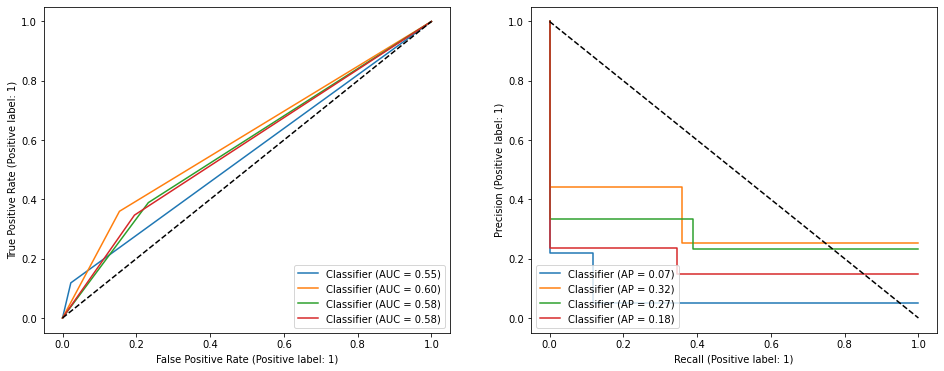

In [41]:
evaluate_threshold(model, dataset.x_val, dataset.y_val)

# IX. Model Saving
> because we will serve this model into our streamlit app we will save the model to use it later.

In [42]:
pickle.dump(model, open('deployment/backend/models/model.pkl', 'wb'))

# X. Model Inference
> okay after all the training and tuning we will now deploy our model to predict the test data.
> in this case i will inference the test data into the model and see how the model perform on the test data. to validate that the model is ready for production.

> so this what we got the model was able to perform calculate the prediction without any problem. and let's check the performance.

In [43]:
result = dataset.x_test.copy()
result['prediction'] = model.predict(result)
result['AdoptionSpeed'] = dataset.y_test.copy()
result['correct'] = result['prediction'] == result['AdoptionSpeed']
result

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,VideoAmt,Description,PhotoAmt,prediction,AdoptionSpeed,correct
PetID,,,,,,,,,,,,,,,,,,,,,
d1b183683,Dog,Mimi,12,Mixed Breed,Not Specified,Female,Yellow,Cream,Not Specified,Medium,...,Healthy,1,0,Kuala Lumpur,0,Rescue from BDKL. More details please contact ...,2,4,3,False
9b3e95995,Dog,Bailey,14,Mixed Breed,Not Specified,Female,Black,Brown,White,Medium,...,Healthy,1,0,Kuala Lumpur,0,"This is Bailey's journey :- Tuesday, /, lunch ...",11,4,3,False
da3702af2,Cat,Abbot,6,Domestic Short Hair,Not Specified,Female,Gray,Not Specified,Not Specified,Small,...,Healthy,1,0,Selangor,0,"jumpe kat kedai mamak...manja..sape berminat,k...",3,4,2,False
fa2c37e6a,Cat,E.T,1,Domestic Medium Hair,Domestic Medium Hair,Female,Black,Not Specified,Not Specified,Small,...,Healthy,1,0,Kuala Lumpur,0,This is E.T. I found her in my condo lift. She...,4,1,4,False
3796a0068,Cat,Simba,1,Domestic Short Hair,Not Specified,Male,Black,Brown,Gray,Medium,...,Healthy,1,0,Kuala Lumpur,0,Simba loves human companion. Playful at his ag...,1,1,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746fb982c,Dog,"Bubu, Ayden",4,Mixed Breed,Labrador Retriever,Female,Brown,Golden,White,Large,...,Healthy,2,0,Selangor,0,There a 2 lovable and playful but loyal and ma...,4,4,2,False
7b70b7048,Cat,MuaChi,5,Silver,Not Specified,Female,Black,Gray,White,Small,...,Healthy,1,0,Selangor,0,"nice and pretty fur she got, she's black by ju...",4,3,4,False
8a6d97169,Dog,Sara,36,Poodle,Mixed Breed,Female,Cream,Not Specified,Not Specified,Small,...,Healthy,1,0,Kuala Lumpur,0,"Quiet, obedient and well behaved dog. She does...",2,0,2,False


> we still not nice result witch in this case around 41% in accuracy

In [44]:
print(classification_report(result['AdoptionSpeed'], result['prediction']))

              precision    recall  f1-score   support

           0       0.04      0.07      0.05        41
           1       0.36      0.41      0.38       309
           2       0.38      0.28      0.32       404
           3       0.37      0.32      0.34       326
           4       0.54      0.64      0.58       420

    accuracy                           0.41      1500
   macro avg       0.34      0.34      0.34      1500
weighted avg       0.41      0.41      0.41      1500



# XI. Conclusion
> okay let's summarize the **insights of this project**.

>> from the start the dataset that we pick is quite small and contain no missing value but the majority of the data is categorical that mean we need to perform analysis on the of how they are made then from decide how we should encode them like the Breed category is we use ordinal encoder it will be problematic because if there are new breed that we don't know about we will get an error because we don't know how to encode them. so in this case i choose to use One Hot Encoder because it ability to separate the categorical data into different columns. so for each of the representation will have different probabilistic value without affecting another feature in another word every type is independent of each other. and it came with an advantage when we encounter new Breed that we have never seen before it will just turn off any column associated with Breed and zeroing the effect of Breed Feature so the model will be more depending on the another feature.
>
>> and since the dataset already encoded from the source we need to decode it back to the original value. so will have better grip to understand the meaning of the data.
>
>> the dataset that we use has hard tendency to distinguish between the classes so we will not trow any feature, because from human perspective i cannot decide which is the best feature to use. so for the better off the model performance i will throw that decision to the model itself
>
>> after trying 4 model and evaluating their performance we have an interesting result that the model base on the tree is performing significantly better than the other type of model. this is in fact correlated linearly with the number of data that we have because i believe such deep learning model is more likely to perform well on the dataset that we have if we have more data a lot more in this case since deep learning model usualy perform better with data around more than 100.000 sample at minimum. so i decide to use tree base model and with help of gradient boosting to regularize the model.
>
>> we're evaluating the model with `cohen_kappa_score` because i want to take the dataset class imbalance into consideration because i want the model to understand that every class is equally important despite the class imbalance. and alongside it, I use `MSE` to see the true numerical performance of the model since metric can deceive us
>
>> we're using `cross_val_score` to evaluate the model performance because we want to see the model performance in sparse dataset. and look for the most stable model because stability of the model represent the model performance in difference distribution of the dataset
>
>> we not do any kind minority balancing technique because i don't want to disrupt their original distribution since we will deploy this model into real world. and we're only using custom weights to balance the model loss function.
>
>> and the model that has the best performance in this case is the tree based model or more specifically the gradient boosting model (LGBM) with random forest as base estimator. this is because tree base model have tendency to be over fitted to dataset and with the help of the gradient boosting model we can regularize the model and make it more robust to the new data. this is because instead of growing tree vertically we grow them horizontally this is called as Stump. because when we plot it it doesn't look like a tree but it looks like a stump, and it is called (Weak Learner) then after that we use gradient to calculate each model weight so every stump will contribute to the final output base on their respective weight.
>
>> because we want to deploy our model into an webapp we neet to export our model to single file to easily deploy the model
>
>> to better understand the model we should exploit the app that we deploy to see witch feature are important because categorical features are very hard to understand let alone 17 categorical features.